# Prediction Experiments

In [1]:
import numpy as np
import random
import pandas as pd
import scipy.stats
import mplsoccer as mpl
from statsmodels.stats.weightstats import DescrStatsW
import os
os.chdir("..")
import ImputationModel.pitch_control as pc
import UtilFunctions.plot_functions as pf
import UtilFunctions.util_functions as ut
import Experiments.ExperimentPlots as ep
import matplotlib.pyplot as plt

## Load in results data from ML models
Get these results data by running the models in the ImputationModel folder, and storing results in dataframes (explained at the bottom of the PlayerPositionImputation notebook)

Data must be the same for each of the models for these experimental comparisons to work

In [2]:
#Load data in for final imputation model and set time to seconds
agent_imputer = pd.read_csv('ModelResults/sorted_results_gnn_timeupdated_test.csv')
agent_imputer_train = pd.read_csv('ModelResults/sorted_results_gnn_timeupdated_train.csv')
agent_imputer['event_time'] = agent_imputer['event_time'] / 1000
agent_imputer_train['event_time'] = agent_imputer_train['event_time'] / 1000

#Load in other machine learning model results
lstm_results = pd.read_csv('ModelResults/sorted_results_lstm_timeupdated.csv')
xgboost_results = pd.read_csv('ModelResults/xgboost_preds_time.csv')
gnn_results = pd.read_csv('ModelResults/sorted_results_gnnor_time.csv')

#Load in naive baseline results
baseline1_results = pd.read_csv('ModelResults/baseline_1_results.csv')
baseline2_results = pd.read_csv('ModelResults/baseline_2_results.csv')
baseline3_results = pd.read_csv('ModelResults/baseline_3_results.csv')

#Include other features for xgboost results
xgboost_results['player_on_ball'] = agent_imputer['player_on_ball'].copy()
xgboost_results['time_since_seen'] = agent_imputer['player_on_ball'].copy()
xgboost_results.loc[xgboost_results['player_on_ball'] == True, 'dist'] = 0
xgboost_results['team_on_ball'] = agent_imputer['team_on_ball'].copy()
xgboost_results['position'] = agent_imputer['position'].copy()

## Experiment 1 - Comparing Distance Error for Player Role

In [3]:
agent_imputer = agent_imputer.dropna(subset=['position'])
agent_imputer_train = agent_imputer_train.dropna(subset=['position'])
print("Unique positions: ", agent_imputer['position'].unique())

Unique positions:  ['GK' 'LWB' 'CB' 'RWB' 'CM' 'CAM' 'CF' 'CDM' 'LB' 'RB' 'LW' 'RW' 'RM' 'LM']


#### Get x and y error for train and test results

In [4]:
agent_imputer['x_dist'] = abs(agent_imputer['act_x'] - agent_imputer['pred_x'])
agent_imputer['y_dist'] = abs(agent_imputer['act_y'] - agent_imputer['pred_y'])
agent_imputer_train['x_dist'] = abs(agent_imputer_train['act_x'] - agent_imputer_train['pred_x'])
agent_imputer_train['y_dist'] = abs(agent_imputer_train['act_y'] - agent_imputer_train['pred_y'])

#### Optional: Convert positions to generic positions

In [5]:
agent_imputer = ut.convert_positions_to_generic(agent_imputer.copy())
agent_imputer_train = ut.convert_positions_to_generic(agent_imputer_train.copy())

#### Create grouped dataframes with mean errors for each role

In [6]:
agent_positions_count_train = agent_imputer_train[['dist','x_dist','y_dist','position']].groupby('position').size()
agent_positions_error_train = agent_imputer_train[['dist','x_dist','y_dist','position']].groupby('position').mean()
agent_positions_std_train = agent_imputer_train[['dist','x_dist','y_dist','position']].groupby('position').std()
agent_positions_count = agent_imputer[['dist','x_dist','y_dist','position']].groupby('position').size()
agent_positions_error = agent_imputer[['dist','x_dist','y_dist','position']].groupby('position').mean()
agent_positions_std = agent_imputer[['dist','x_dist','y_dist','position']].groupby('position').std()
position_errors_combined = pd.concat([agent_positions_error_train,agent_positions_error],axis=1)
position_errors_combined.columns = ['train_dist','train_x_dist','train_y_dist','test_dist','test_x_dist','test_y_dist']
position_errors_combined

,train_dist,train_x_dist,train_y_dist,test_dist,test_x_dist,test_y_dist
position,,,,,,
Central Attacker,8.047307,4.373897,5.779534,8.307636,4.393899,6.053412
Central Defender,5.455378,3.420634,3.496897,5.797878,3.596751,3.753383
Central Midfielder,6.730992,4.079505,4.466406,7.374535,4.265244,5.128321
Goalkeeper,2.848695,2.241742,1.288351,2.628350,2.015128,1.238802
Wide Attacker,7.578062,4.697391,4.876048,7.992306,4.669483,5.401043
Wide Defender,6.239914,4.403373,3.509964,7.064811,5.142243,3.821133
Wide Midfielder,7.718824,5.261125,4.471640,7.039781,5.011739,3.868308


#### Optional: Get the average error for wide and central players

In [7]:
print("Average X Error Wide: ", position_errors_combined.loc[['Wide Defender','Wide Midfielder','Wide Attacker'],'test_x_dist'].mean())
print("Average X Error Central: ", position_errors_combined.loc[['Central Defender','Central Midfielder','Central Attacker'],'test_x_dist'].mean())
print("Average Y Error Wide: ", position_errors_combined.loc[['Wide Defender','Wide Midfielder','Wide Attacker'],'test_y_dist'].mean())
print("Average Y Error Central: ", position_errors_combined.loc[['Central Defender','Central Midfielder','Central Attacker'],'test_y_dist'].mean())

Average X Error Wide:  4.941155130032581
Average X Error Central:  4.085298185006401
Average Y Error Wide:  4.363494934568381
Average Y Error Central:  4.978371815763063


#### Calculate confidence intervals for error per position

In [8]:
samples_train = agent_imputer_train['position'].value_counts().sort_index()
samples_test = agent_imputer['position'].value_counts().sort_index()
agent_positions_std_train = ut.get_standard_errors_all_directions(agent_positions_std_train,samples_train)
agent_positions_std = ut.get_standard_errors_all_directions(agent_positions_std,samples_test)

#### Load Plot
Must checkout and install: https://github.com/garrettj403/SciencePlots

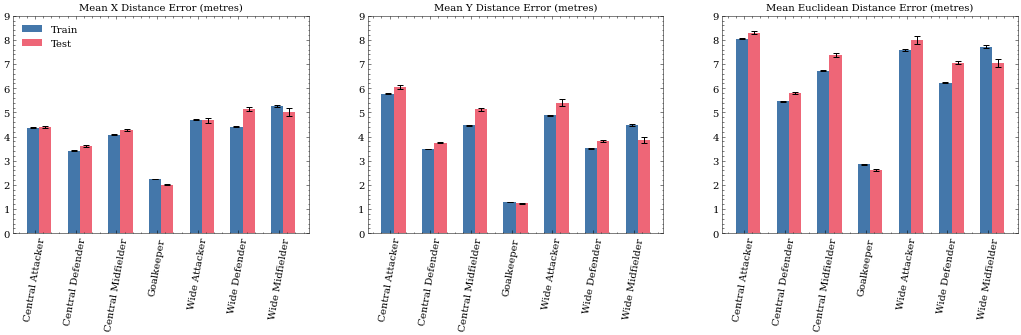

In [9]:
role_error_fig = ep.create_role_error_plot(position_errors_combined,agent_positions_std_train,agent_positions_std,agent_imputer)

## Experiment 2: Get error across time since observation
For up to 20 seconds, calculate error of the model when it's been a certain amount of time since the agent was last seen (e.g. between 1 and 2 seconds). Show how error changes over time since observation

In [10]:
#Calculates time since last and next seen and adds to dataframes
gnn_results = ut.get_time_since_seen(gnn_results)
lstm_results = ut.get_time_since_seen(lstm_results)
agent_imputer = ut.get_time_since_seen(agent_imputer)
xgboost_results = ut.get_time_since_seen(xgboost_results)

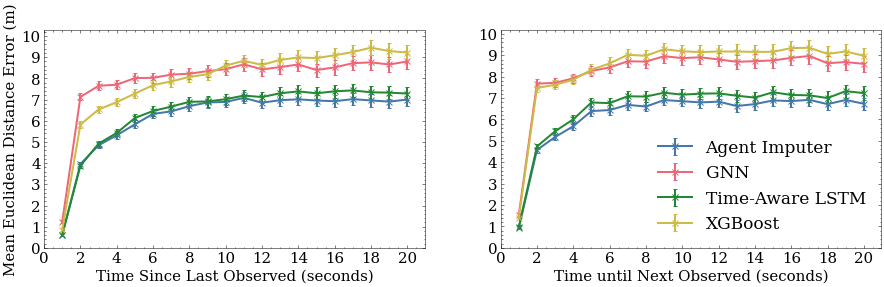

In [11]:
fig_observation = ep.create_error_across_observation_time_plot(agent_imputer,lstm_results,gnn_results,xgboost_results)

## Experiment 3: Distance Error over Time
Gets the distance error over time and see how error changes through game periods. Performs t-tests to validate results.

#### Plot error over period

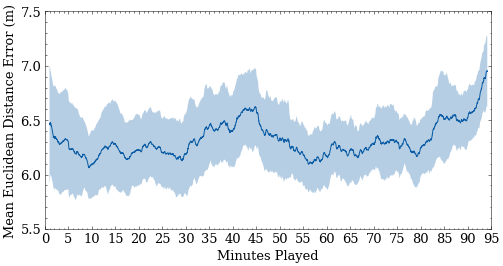

In [12]:
agent_imputer_all = pd.concat([agent_imputer_train,agent_imputer],axis=0)

#Split distances for each time, then get rolling average over a game for each second (5 minute rolling average)
event_time_dist=agent_imputer_all.groupby('event_time').mean()[['match_id','dist']]
match_ids = np.array(agent_imputer_all['match_id'].unique())
means_time_df = ut.get_rolling_average_error(event_time_dist,match_ids)
fig_periods = ep.plot_error_over_game_periods(means_time_df)

#### T-tests for middle and end of halves

In [13]:
#Get error for different periods
etd = event_time_dist.copy()
etd.index = etd.index/60
etd_midfirst = etd[(etd.index > 20) & (etd.index < 25)]['dist']
etd_endfirst = etd[(etd.index > 42.5) & (etd.index < 47.5)]['dist'].sample(len(etd_midfirst))
etd_midsecond = etd[(etd.index > 65) & (etd.index < 70)]['dist']
etd_endsecond = etd[(etd.index > 87.5) & (etd.index < 92.5)]['dist'].sample(len(etd_midsecond))

print("T-test for first half: ", scipy.stats.ttest_rel(etd_midfirst, etd_endfirst, alternative='less'))
print("T-test for second half: ", scipy.stats.ttest_rel(etd_midsecond, etd_endsecond, alternative='less'))

T-test for first half:  Ttest_relResult(statistic=-4.330934204038023, pvalue=7.6109239842831885e-06)
T-test for second half:  Ttest_relResult(statistic=-8.805362937073092, pvalue=1.1490819826301153e-18)


## Application 1: Distance Covered
Gets distance for each player, try and get actual distances from tracking data

In [14]:
agent_imputer_dist_covered = agent_imputer.copy()

In [15]:
dist_df = ut.distance_covered_metric(agent_imputer_dist_covered, True)
dist_df_by_position = dist_df.groupby('position').mean()
print("Average distance covered (m) per position: ")
dist_df_by_position

Average distance covered (m) per position: 


,player,match,mins,pred_dist,act_dist,error,dist_per_90,dist_act_per_90,err_p_90
position,,,,,,,,,
Central Attacker,152047.500000,42935.375000,61.468598,5740.098842,5628.643143,6.523997,8399.286059,8353.959566,6.523997
Central Defender,157482.000000,42937.285714,69.631238,6206.821717,6437.549610,5.286627,8100.947030,8418.239907,5.286627
Central Midfielder,158660.647059,42937.705882,55.033933,5724.273382,5752.699270,3.881236,9413.493902,9503.603607,3.881236
Goalkeeper,102582.666667,42936.000000,76.193217,2743.259005,2653.131951,3.625557,3232.208647,3120.259436,3.625557
Wide Attacker,131648.500000,42937.000000,66.708858,6088.856522,6439.307118,5.509200,8251.341470,8704.686736,5.509200
Wide Defender,132446.363636,42936.636364,64.610721,6428.550304,6454.594305,5.586172,8998.703748,9090.143995,5.586172
Wide Midfielder,201865.500000,42937.000000,85.926583,8272.502245,8567.037109,3.554790,8664.666663,8973.164182,3.554790


## Application 2: Pitch Control

In [ ]:
random.seed(39)
pc_errors_ai = []
pc_errors_lstm = []
pc_errors_xg = []
pc_errors_gnn = []

#Loop through event samples
for e in random.sample(list(agent_imputer['event_id'].unique()), 1):
    
    #Calculate the pitch control for each model using their predicted positions of players
    print("PITCH CONTROL FOR EVENT: ", e)
    PPCFa_ai, ax = ut.calculate_model_pitch_control(agent_imputer, e, False)
    PPCFa_lstm, ax = ut.calculate_model_pitch_control(lstm_results, e, False)
    PPCFa_xg, ax = ut.calculate_model_pitch_control(xgboost_results, e, False)
    PPCFa_gnn, ax = ut.calculate_model_pitch_control(gnn_results, e, False)
    PPCFa_actual, ax = ut.calculate_model_pitch_control(agent_imputer, e, True)
    
    #Calculate MAE difference between model predictions and actual pitch control
    pc_errors_ai.append(abs(PPCFa_ai-PPCFa_actual).mean())
    pc_errors_lstm.append(abs(PPCFa_lstm-PPCFa_actual).mean())
    pc_errors_xg.append(abs(PPCFa_xg-PPCFa_actual).mean())
    pc_errors_gnn.append(abs(PPCFa_gnn-PPCFa_actual).mean())
    print("MAE AGENT IMPUTER: ", abs(PPCFa_ai-PPCFa_actual).mean())
    print("MAE LSTM: ", abs(PPCFa_lstm-PPCFa_actual).mean())
    print("MAE XG: ", abs(PPCFa_xg-PPCFa_actual).mean())
    print("MAE GNN: ", abs(PPCFa_gnn-PPCFa_actual).mean())

#### Calculate mean errors of each model pitch control

In [4]:
print("MEAN ERROR AGENT IMPUTER: ", np.array(pc_errors_ai).mean())
print("MEAN ERROR LSTM: ", np.array(pc_errors_lstm).mean())
print("MEAN ERROR XGBOOST: ", np.array(pc_errors_xg).mean())
print("MEAN ERROR GNN: ", np.array(pc_errors_gnn).mean())

MEAN ERROR AGENT IMPUTER:  0.1383254325840715
MEAN ERROR LSTM:  0.1277200862404207
MEAN ERROR XGBOOST:  0.15050064035732832
MEAN ERROR GNN:  0.14197746742020512


## Application 3: Player Heatmaps
Show a predicted and actual heatmap for players to show usefulness of applying imputed data to such tasks

In [5]:
print("Unique match and player ids: ")
unique_player_matches = agent_imputer[['player_id','position','match_id']].drop_duplicates().head(5)
unique_player_matches

Unique match and player ids: 


,player_id,position,match_id
0,143591,GK,42926
1,188184,LWB,42926
2,215548,CB,42926
3,215699,CB,42926
4,188185,CB,42926


C:\Apps\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Apps\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

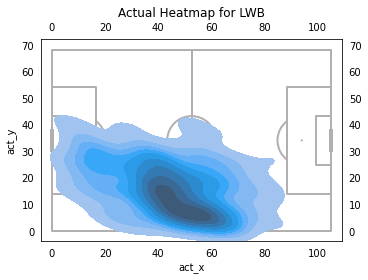

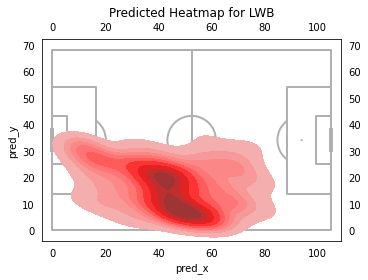

In [6]:
ut.get_player_heatmaps(agent_imputer, unique_player_matches.loc[1,'player_id'],unique_player_matches.loc[1,'match_id'], unique_player_matches.loc[1,'position'])